In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import layers, models
from keras import backend as K

from keras.utils import plot_model

from sklearn.utils import shuffle
import os
import multiprocessing
from pathlib import Path
from IPython.display import Image

from utils.DomainImageGenerator import DomainImageGenerator

2025-07-25 12:21:37.981208: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the Dataset as Generators so not all images are loaded into ram at the same time. The generator class loads the needed images per batch
cpu_count = multiprocessing.cpu_count()
njobs = int(cpu_count * 0.9) # Just set to use some percent of cpus
max_queue_size = 15
use_multiprocessing = True

train_gen = DomainImageGenerator("prepared/train.csv", batch_size=64, img_size=(32, 32), shuffle=True, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size) # "batch_size=64, img_size=(32, 32), shuffle=True]" are the default values
val_gen = DomainImageGenerator("prepared/valid.csv", batch_size=64, n_jobs=njobs, use_multiprocessing=use_multiprocessing, max_queue_size=max_queue_size)

train_gen.set_Mode_To_Rescale(rescale=True)
val_gen.set_Mode_To_Rescale(rescale=True)

In [3]:
### Load the Dataset without a generator (not recommended)
### x contains an array with dimensions (n_samples, 32, 32, 3) where 32x32 is the image size and 3 is for the different color channels
### The values are scaled between 0 and 1
### y contains an array with dimensions (n_samples, 1) where the labels are given as either 0 or 1

# from utils.utils_ModelTraining import load_data_all_splits, prepare_dataset
# train_df, val_df, test_df = load_data_all_splits()

# print("Train Data")
# x_train, y_train = prepare_dataset(train_df)
# print("Validation Data")
# x_val, y_val = prepare_dataset(val_df)

In [4]:
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),
    layers.Conv2D(2, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(5, (3, 3), activation='relu'),
    #layers.MaxPooling2D(),
    layers.Flatten(),
    #layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

2025-07-18 16:42:28.500696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 2)      │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 2)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 450)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 507 (1.98 KB)

 Trainable params: 507 (1.98 KB)

 Non-trainable params: 0 (0.00 B)

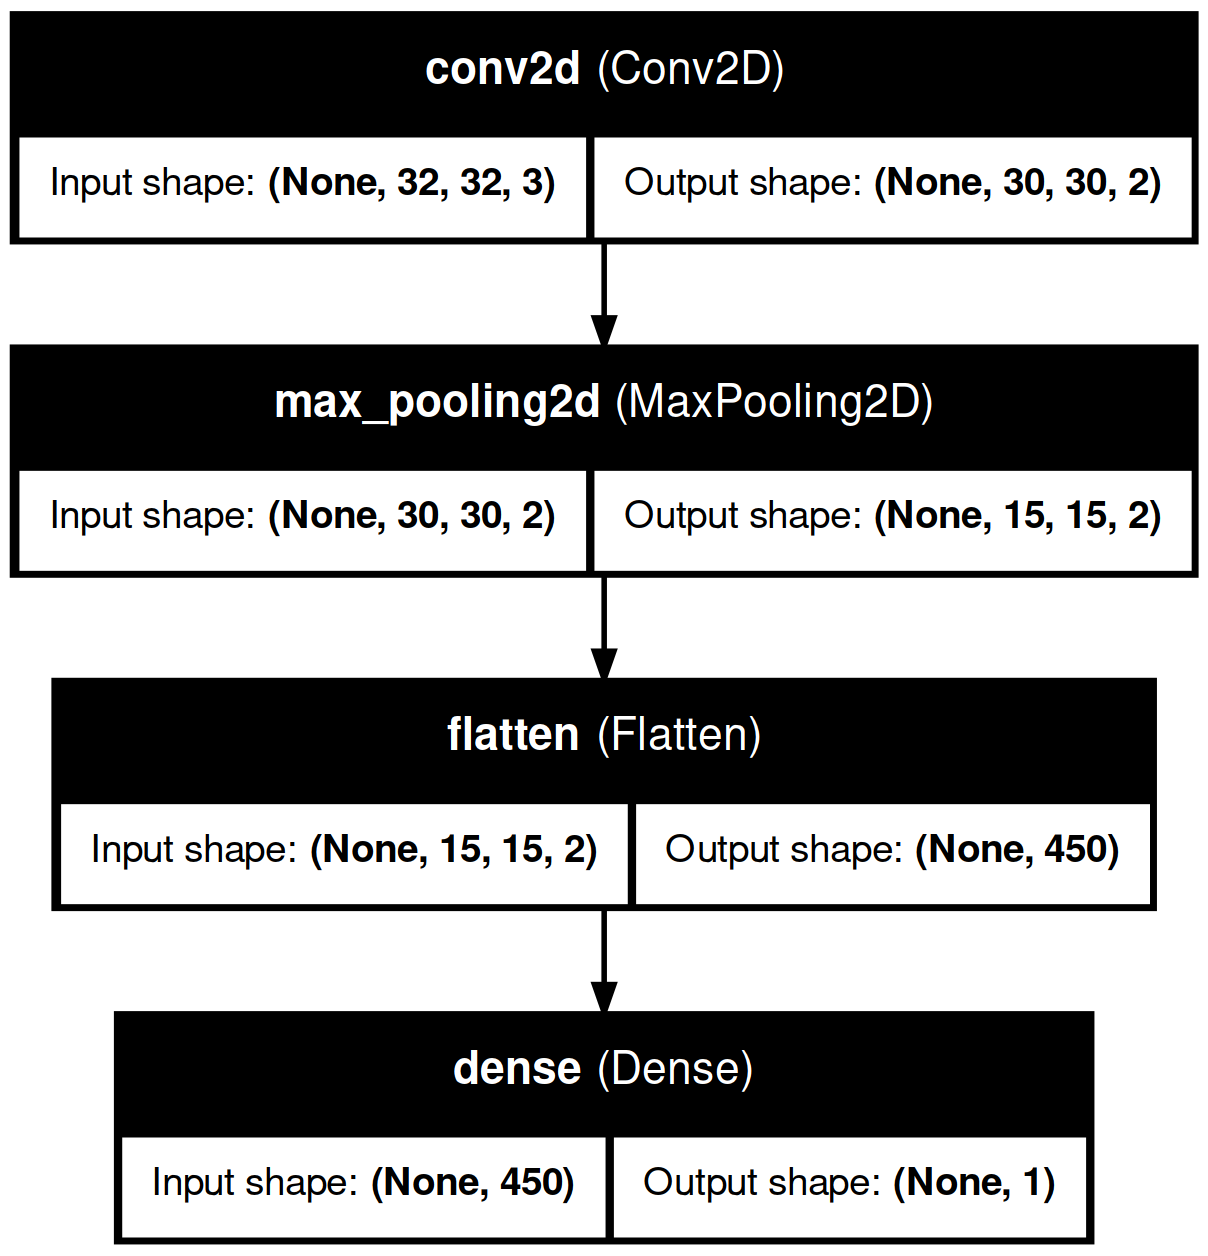

In [6]:
Path("build").mkdir(parents=True, exist_ok=True)
Path("build/MinimalModelRescaledImages").mkdir(parents=True, exist_ok=True)

plot_model(model, to_file='build/MinimalModelRescaledImages/Model.png', show_shapes=True, show_layer_names=True)
Image('build/MinimalModelRescaledImages/Model.png')

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=55,
    verbose=1
)

Epoch 1/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 16ms/step - accuracy: 0.7776 - loss: 0.5290 - val_accuracy: 0.7777 - val_loss: 0.5096
Epoch 2/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.7785 - loss: 0.4971 - val_accuracy: 0.7775 - val_loss: 0.4732
Epoch 3/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7778 - loss: 0.4710 - val_accuracy: 0.7803 - val_loss: 0.4589
Epoch 4/55
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.7801 - loss: 0.4588 - val_accuracy: 0.7889 - val_loss: 0.4499
Epoch 5/55
1204/1407 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7851 - loss: 0.4461

In [ ]:
print(history.history.keys())

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("build/MinimalModelRescaledImages/Loss.png")
plt.show()

In [ ]:
model.save("../models/MinimalModelRescaledImages.keras")